<a href="https://colab.research.google.com/github/yeye-cyber/DL-project/blob/master/problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip3 install gym[box2d]




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp38-cp38-linux_x86_64.whl size=2122243 sha256=47fd78e37090bfe20931370dfd88907d011892e0b6cebf8d43a81f10c9df5c94
  Stored in directory: /root/.cache/pip/wheels/8b/95/16/1dc99ff9a3f316ff245fdb5c9086cd13c35dad630809909075
Successfully built box2d-py


Network model: Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=4, bias=True)
)
Plot Value function 


/usr/local/lib/python3.8/dist-packages/numpy/lib/stride_tricks.py:341: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.array(array, copy=False, subok=subok)
/usr/local/lib/python3.8/dist-packages/numpy/lib/stride_tricks.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array, copy=False, subok=subok)


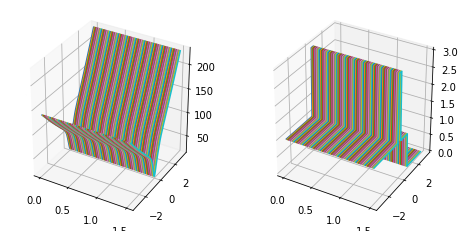

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Episode 47 - Reward/Steps: -87.7/94 - Avg. Reward/Steps: 0.0/0:  10%|▉         | 48/500 [00:01<00:12, 37.37it/s]<ipython-input-58-25f05bfbc96e>:109: UserWarning: Using a target size (torch.Size([1, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(
Epis

In [ ]:
from ast import arguments
from torch.nn.functional import threshold

from torch.nn.modules.linear import Linear
from torch.nn.modules.activation import ReLU
import numpy as np
import gym
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib import cm



class Agent(object):
    ''' Base agent class, used as a parent class

        Args:
            n_actions (int): number of actions

        Attributes:
            n_actions (int): where we store the number of actions
            last_action (int): last action taken by the agent
    '''
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
        self.last_action = None

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass


class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''
    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> int:
        ''' Compute an action uniformly at random across n_actions possible
            choices

            Returns:
                action (int): the random action
        '''
        self.last_action = np.random.randint(0, self.n_actions)
        return self.last_action


class DQN(nn.Module):
      def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
      def forward(self, state):
        ''' Performs a forward computation '''
        return self.network(state)
        
   
class DQNAgent(Agent):

    def __init__(self, dim_state, n_actions: int):
      super(DQNAgent, self).__init__(n_actions)
      self.main_network = DQN(dim_state, n_actions)
      self.target_network = DQN(dim_state, n_actions)
      self.optimizer = optim.Adam(self.main_network.parameters(), lr)
        

    def forward(self, state: np.ndarray, eps):
        ''' Performs a forward computation '''
                # Take epsilon-greedy action
        if random.random() < eps:
          self.last_action = np.random.randint(0, self.n_actions)
        else:
           state_tensor = torch.tensor([state],
                                    requires_grad=False,
                                    dtype=torch.float32)
           values = self.main_network(state_tensor)
           self.last_action = values.max(1)[1].item()
        return self.last_action
        

    def backward(self, buffer):
        ''' Performs a backward pass on the network '''
        states, actions, rewards, next_states, dones = buffer.sample_batch(N)

        actions = torch.tensor(actions,
                          requires_grad=False)
        
        values = self._Q(states,actions) 

        target_values = self._y(next_states, rewards, dones)
        
      # Compute loss function
        loss = nn.functional.mse_loss(
                          values,target_values)

      # Compute gradient
        self.optimizer.zero_grad()
        loss.backward()

      # Clip gradient norm to 1
        nn.utils.clip_grad_norm_(self.main_network.parameters(), max_norm=1.)

      # Perform backward pass (backpropagation)
        self.optimizer.step()

        
    def _Q(self, states, actions):
      values = self.main_network(torch.tensor(states,
                          requires_grad=True,
                          dtype=torch.float32)).gather(1, actions.unsqueeze(-1)).squeeze(-1) 
      return values   
    
    def _y(self, next_states, rewards, dones):

      next_values = self.target_network(torch.tensor(next_states,
                          requires_grad=False,
                          dtype=torch.float32))
      rewards = torch.tensor([rewards],
                          requires_grad=False,
                          dtype=torch.float32)
        
      target_values = rewards + discount_factor * next_values.max(1)[0]
        
      for j in range(len(next_values)):
        if dones[j] == True:
          target_values[0][j] = rewards[0][j]
      return target_values
          



Experience = namedtuple('Experience',
                        ['state', 'action', 'reward', 'next_state', 'done'])

class ExperienceReplayBuffer(object):
    """ Class used to store a buffer containing experiences of the RL agent.
    """
    def __init__(self, maximum_length):
        # Create buffer of maximum length
        self.buffer = deque(maxlen=maximum_length)

    def append(self, experience):
        # Append experience to the buffer
        self.buffer.append(experience)

    def __len__(self):
        # overload len operator
        return len(self.buffer)

    def sample_batch(self, n):
        """ Function used to sample experiences from the buffer.
            returns 5 lists, each of size n. Returns a list of state, actions,
            rewards, next states and done variables.
        """
        # If we try to sample more elements that what are available from the
        # buffer we raise an error
        if n > len(self.buffer):
            raise IndexError('Tried to sample too many elements from the buffer!')

        # Sample without replacement the indices of the experiences
        # np.random.choice takes 3 parameters: number of elements of the buffer,
        # number of elements to sample and replacement.
        indices = np.random.choice(
            len(self.buffer),
            size=n,
            replace=False
        )

        # Using the indices that we just sampled build a list of chosen experiences
        batch = [self.buffer[i] for i in indices]

        # batch is a list of size n, where each element is an Experience tuple
        # of 5 elements. To convert a list of tuples into
        # a tuple of list we do zip(*batch). In this case this will return a
        # tuple of 5 elements where each element is a list of n elements.
        return zip(*batch)

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def linear_decay(eps_min, eps_max, k, N_episodes):
  Z = N_episodes*0.9
  return max(eps_min,eps_max - ((eps_max-eps_min)*(k-1))/(Z-1))

def plot3D():
    # Load model
  try:
      model = torch.load('neural-network-1.pth')
      print('Network model: {}'.format(model))
  except:
      print('File neural-network-1.pth not found!')
      exit(-1)

  print('Plot Value function ')
  
  points = 100
  ys = np.linspace(0, 1.5, points) 
  omegas = np.linspace(-np.pi,np.pi, points)
  values = []
  actions = []

  for i in range(points)  :
      # Get next state and reward.  The done variable
      # will be True if you reached the goal position,
      # False otherwise
      state = (0, ys[i], 0, 0, omegas[i], 0,0,0)
      q_values = model(torch.tensor([state],requires_grad=False,
                                    dtype=torch.float32))
      value, action = torch.max(q_values, axis=1)
      values.append(value.item())
      actions.append(action)
    


  fig = plt.figure(figsize=plt.figaspect(0.5))
  ax1 = fig.add_subplot(1, 2, 1, projection='3d')
  ax2 = fig.add_subplot(1, 2, 2, projection='3d')
  ys, omegas = np.meshgrid(ys, omegas)
  ax1.plot(ys, omegas, values)
  ax2.plot(ys, omegas, actions)

  plt.show()

plot3D()
# Import and initialize the discrete Lunar Laner Environment
env = gym.make('LunarLander-v2')
env.reset()

# Parameters
N_episodes = 500                      # Number of episodes
discount_factor = 0.99                    # Value of the discount factor
n_ep_running_average = 50                    # Running average of 50 episodes
n_actions = env.action_space.n               # Number of available actions
dim_state = len(env.observation_space.high)  # State dimensionality
eps_max = 0.99
eps_min = 0.05
N = 64
lr=0.0001
buffer_size = 15000
target_update = round(buffer_size/N)
avr_reward_threshold = 50
# We will use these variables to compute the average episodic reward and
# the average number of steps per episode
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode

buffer = ExperienceReplayBuffer(maximum_length=buffer_size)
#print(dim_state)
#print(n_actions)
# Random agent initialization
#agent_random = RandomAgent(n_actions)
agent_DQN = DQNAgent(dim_state, n_actions)


### Training process

# trange is an alternative to range in python, from the tqdm library
# It shows a nice progression bar that you can update with useful information
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)

for i in EPISODES:
  
    # Reset enviroment data and initialize variables
    done = False
    state = env.reset()
    total_episode_reward = 0
    t = 0
    eps = linear_decay(eps_min, eps_max, i+1, N_episodes)
    while not done:
        action = agent_DQN.forward(state, eps)
        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise
        next_state, reward, done, _ = env.step(action)
        exp = Experience(state, action, reward, next_state, done)
        buffer.append(exp)
        if len(buffer) >= buffer_size *0.3:
          agent_DQN.backward(buffer)

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        state = next_state
        t+= 1

        if  t % target_update == 0:
          agent_DQN.target_network.load_state_dict(agent_DQN.main_network.state_dict())
        
    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    # Close environment
    env.close()

    # Updates the tqdm update bar with fresh information
    # (episode number, total reward of the last episode, total number of Steps
    # of the last episode, average reward, average number of steps)
    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

    if running_average(episode_reward_list, n_ep_running_average)[-1] > avr_reward_threshold:
      break

torch.save(agent_DQN.main_network.network, 'neural-network-1.pth')
# Plot Rewards and steps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, i+2)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, i+2)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1,i+2)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, i+2)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()





In [ ]:
!python3 DQN_check_solution.py

Network model: Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=4, bias=True)
)
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Checking solution...
Episode 0:   0% 0/50 [00:00<?, ?it/s]DQN_check_solution.py:65: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please 